In [1]:
import numpy as np

In [2]:
import keras

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,Dropout,LayerNormalization

In [4]:
from tensorflow.keras import Model

In [5]:
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention,self).__init__()
        
    def call(self,encoder_op,decoder_op):
        decoder_op=tf.transpose(decoder_op,perm=(0,2,1))
        score=tf.matmul(encoder_op,decoder_op)
        attention_wts=tf.nn.softmax(score,axis=-1)
        attention_wts=tf.transpose(attention_wts,perm=(0,2,1))
        context_vector=tf.matmul(attention_wts,encoder_op)
        return context_vector

In [25]:
encoder_inputs=Input(shape=(src_max_len,))
encoder_embedding=Embedding(src_vocab_size,embed_dim,trainable=True,embeddings_initializer="glorot_uniform")
encoder_embed=encoder_embedding(encoder_inputs)
encoder_lstm=LSTM(lstm_units,return_state=True,return_sequences=True)
encoder_op,encoder_hidden,encoder_cell=encoder_lstm(encoder_embed)

decoder_inputs=Input(shape=(None,))
decoder_embedding=Embedding(trg_vocab_size,embed_dim,trainable=True,embeddings_initializer="glorot_uniform")
decoder_embed=decoder_embedding(decoder_inputs)
decoder_lstm=LSTM(lstm_units,return_state=True,return_sequences=True)
decoder_op,decoder_hidden,decoder_cell=decoder_lstm(decoder_embed)

attention=Attention()
context_vector=attention(encoder_op,decoder_op)

p_gen_dense=Dense(1)
p_vocab_dense=Dense(trg_vocab_size)
p_context_vector=Dense(trg_vocab_size)

p_gen_combined=tf.concat([context_vector,decoder_op,decoder_embed],axis=-1)
p_vocab_combined=tf.concat([context_vector,decoder_op],axis=-1)

p_gen=p_gen_dense(p_gen_combined)
p_vocab=p_vocab_dense(p_vocab_combined)

context_vector=p_context_vector(context_vector)

prob=p_gen*p_vocab+(1-p_gen)*context_vector

model=Model([encoder_inputs,decoder_inputs],prob)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 50)]                 0         []                            
                                                                                                  
 input_21 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 50, 10)               10000     ['input_20[0][0]']            
                                                                                                  
 embedding_19 (Embedding)    (None, None, 10)             5000      ['input_21[0][0]']            
                                                                                              

In [6]:
import pandas as pd

In [7]:
df=pd.read_csv("test.csv")

In [8]:
df.head()

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


In [74]:
X=df["article"]

In [75]:
y=df["highlights"]

In [76]:
len(X),len(y)

(11490, 11490)

In [77]:
X=X[:500]
y=y[:500]

In [78]:
len(X),len(y)

(500, 500)

In [79]:
import re

def clean_sentences(sentences):
    cleaned_sentences = []

    def replace_non_alphabetic_with_null(input_string):
        return re.sub(r'[^a-zA-Z0-9.,?\s]', '', input_string)

    for sentence in sentences:
        sentence=sentence.replace('\n',' ')
        cleaned_sentence = replace_non_alphabetic_with_null(sentence)
        cleaned_sentence=cleaned_sentence.lower()
        cleaned_sentences.append(cleaned_sentence)

    return cleaned_sentences

In [80]:
cleaned_x=clean_sentences(X)
cleaned_y=clean_sentences(y)

In [81]:
y[1]

"Drunk teenage boy climbed into lion enclosure at zoo in west India .\nRahul Kumar, 17, ran towards animals shouting 'Today I kill a lion!'\nFortunately he fell into a moat before reaching lions and was rescued ."

In [82]:
cleaned_y[1]

'drunk teenage boy climbed into lion enclosure at zoo in west india . rahul kumar, 17, ran towards animals shouting today i kill a lion fortunately he fell into a moat before reaching lions and was rescued .'

In [83]:
cleaned_y=["<start> "+i+" <end>" for i in cleaned_y]

In [84]:
cleaned_y[1]

'<start> drunk teenage boy climbed into lion enclosure at zoo in west india . rahul kumar, 17, ran towards animals shouting today i kill a lion fortunately he fell into a moat before reaching lions and was rescued . <end>'

In [85]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [86]:
SRCTokenizer=Tokenizer(oov_token="<OOV>")
TRGTokenizer=Tokenizer(oov_token="<OOV>")

SRCTokenizer.fit_on_texts(cleaned_x)
inp_sequences=SRCTokenizer.texts_to_sequences(cleaned_x)

TRGTokenizer.fit_on_texts(cleaned_y)
trg_sequences=TRGTokenizer.texts_to_sequences(cleaned_y)

In [87]:
select_inp=[len(i) for i in inp_sequences]

In [88]:
max_inp_len1=sum(select_inp)//len(select_inp)

In [89]:
max_inp_len1

642

In [90]:
select_tar=[len(i) for i in trg_sequences]
max_tar_len1=sum(select_tar)//len(select_tar)
max_tar_len1

52

In [59]:
max_inp_len=max([len(i) for i in inp_sequences])
max_tar_len=max([len(i) for i in trg_sequences])

max_inp_len,max_tar_len

(1538, 116)

In [91]:
inputs=pad_sequences(inp_sequences,padding="post",maxlen=max_inp_len1)
outputs=pad_sequences(trg_sequences,padding="post",maxlen=max_tar_len1)

In [92]:
SRC_vocab=SRCTokenizer.word_index
TRG_vocab=TRGTokenizer.word_index

src_vocab_size=len(SRC_vocab)+1
trg_vocab_size=len(TRG_vocab)+1

src_vocab_size,trg_vocab_size

(24278, 7003)

In [93]:
embed_dim=100
lstm_units=200

In [29]:
from tensorflow.keras.layers import LayerNormalization

In [94]:
encoder_inputs=Input(shape=(max_inp_len1,))
encoder_embedding=Embedding(src_vocab_size,embed_dim)
encoder_embed=encoder_embedding(encoder_inputs)
encoder_lstm=LSTM(lstm_units,return_state=True,return_sequences=True)
encoder_op,encoder_hidden,encoder_cell=encoder_lstm(encoder_embed)


decoder_inputs=Input(shape=(None,))
decoder_embedding=Embedding(trg_vocab_size,embed_dim)
decoder_embed=decoder_embedding(decoder_inputs)
decoder_lstm=LSTM(lstm_units,return_state=True,return_sequences=True)
decoder_op,decoder_hidden,decoder_cell=decoder_lstm(decoder_embed,initial_state=[encoder_hidden,encoder_cell])

attention=Attention()
context_vector=attention(encoder_op,decoder_op)

p_gen_dense=Dense(1,activation="sigmoid")
p_vocab_dense=Dense(trg_vocab_size)
p_context_vector=Dense(trg_vocab_size)

p_gen_combined=tf.concat([context_vector,decoder_op,decoder_embed],axis=-1)
p_vocab_combined=tf.concat([context_vector,decoder_op],axis=-1)

p_gen=p_gen_dense(p_gen_combined)
p_vocab=p_vocab_dense(p_vocab_combined)

context_vector=p_context_vector(context_vector)

prob=p_gen*p_vocab+(1-p_gen)*context_vector

model=Model([encoder_inputs,decoder_inputs],prob)

In [95]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 642)]                0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 642, 100)             2427800   ['input_5[0][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 lstm_4 (LSTM)               [(None, 642, 200),           240800    ['embedding_4[0][0]']         
                              (None, 200),                                                  

In [96]:
expected_loss=np.log(tf.cast(trg_vocab_size,tf.float32))

In [97]:
expected_loss

8.854094

In [98]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01,clipnorm=5)
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [99]:
model.compile(optimizer=optimizer,loss=loss_fn,metrics=["accuracy"])

In [100]:
from sklearn.model_selection import train_test_split

In [101]:
X_train,X_test,y_train,y_test=train_test_split(inputs,outputs,test_size=0.2,random_state=0)

In [102]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((400, 642), (100, 642), (400, 52), (100, 52))

In [103]:
model.evaluate([X_test,y_test[:,:-1]],y_test[:,1:],steps=20,return_dict=True)

20/20 [==============================] - 8s 288ms/step - loss: 8.8539 - accuracy: 0.0000e+00


{'loss': 8.853924751281738, 'accuracy': 0.0}

In [ ]:
H=model.fit([X_train,y_train[:,:-1]],y_train[:,1:],steps_per_epoch=10,epochs=10,
            validation_data=([X_test,y_test[:,:-1]],y_test[:,1:]),
           callbacks=tf.keras.callbacks.EarlyStopping(patience=3))

Epoch 1/10
10/10 [==============================] - 54s 5s/step - loss: 11.7185 - accuracy: 0.1038 - val_loss: 7.4173 - val_accuracy: 0.1386
Epoch 2/10
10/10 [==============================] - 45s 5s/step - loss: 6.8897 - accuracy: 0.1370 - val_loss: 7.2623 - val_accuracy: 0.1390
Epoch 3/10
10/10 [==============================] - 47s 5s/step - loss: 6.3132 - accuracy: 0.1532 - val_loss: 6.9551 - val_accuracy: 0.1647
Epoch 4/10
10/10 [==============================] - 52s 5s/step - loss: 5.9634 - accuracy: 0.1653 - val_loss: 7.1223 - val_accuracy: 0.1751
Epoch 5/10
10/10 [==============================] - 48s 5s/step - loss: 5.6112 - accuracy: 0.1738 - val_loss: 7.4106 - val_accuracy: 0.1788
Epoch 6/10
 8/10 [=======================>......] - ETA: 10s - loss: 5.2224 - accuracy: 0.1851

In [43]:
import matplotlib.pyplot as plt

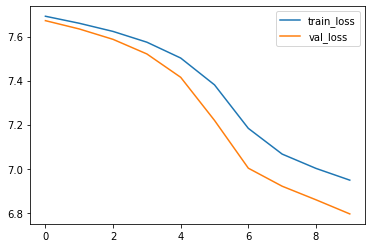

In [45]:
plt.plot(H.history["loss"],label="train_loss")
plt.plot(H.history["val_loss"],label="val_loss")
plt.legend()

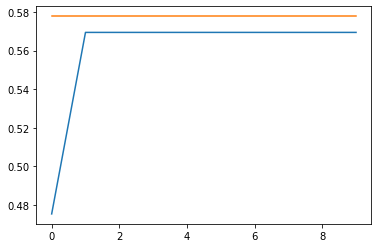

In [44]:
plt.plot(H.history["accuracy"],label="train_accuracy")
plt.plot(H.history["val_accuracy"],label="val_accuracy")

In [45]:
encoder_model=Model(encoder_inputs,[encoder_op,encoder_hidden,encoder_cell])

In [46]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1538)]            0         
                                                                 
 embedding (Embedding)       (None, 1538, 100)         930300    
                                                                 
 lstm (LSTM)                 [(None, 1538, 200),       240800    
                              (None, 200),                       
                              (None, 200)]                       
                                                                 
Total params: 1171100 (4.47 MB)
Trainable params: 1171100 (4.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
decoder_input=Input(shape=(None,))
encoder_opp=Input(shape=(max_inp_len,lstm_units))
encoder_hiddenn=Input(shape=(lstm_units,))
encoder_cells=Input(shape=(lstm_units,))
decoder_embedd=decoder_embedding(decoder_input)
decoder_opp,decoder_hiddenn,decoder_cells=decoder_lstm(decoder_embedd,initial_state=[encoder_hiddenn,encoder_cells])
context_vector1=attention(encoder_opp,decoder_opp)

p_gen_combined1=tf.concat([context_vector1,decoder_opp,decoder_embedd],axis=-1)
p_vocab_combined1=tf.concat([context_vector1,decoder_opp],axis=-1)

p_gen1=p_gen_dense(p_gen_combined1)
p_vocab1=p_vocab_dense(p_vocab_combined1)

context_vector1=p_context_vector(context_vector1)

prob1=p_gen1*p_vocab1+(1-p_gen1)*context_vector1

decoder_model=Model([decoder_input,encoder_opp,encoder_hiddenn,encoder_cells],[prob1,decoder_hiddenn,decoder_cells])

In [50]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 100)            221700    ['input_10[0][0]']            
                                                                                                  
 input_12 (InputLayer)       [(None, 200)]                0         []                            
                                                                                                  
 input_13 (InputLayer)       [(None, 200)]                0         []                            
                                                                                            

In [56]:
TRG_index_word=TRGTokenizer.index_word

In [58]:
TRG_index_word[1]

'<OOV>'

In [65]:
inputs[75,:].shape

(1538,)

In [69]:
y[75]

"Random Darknet Shopper is a computer bot that randomly purchases an item every week from a hidden part of the internet called the dark net .\nSwiss police seized bot after it purchased 10 ecstasy tablets from Germany .\nIt was later released 'without charge' according to the artists behind the bot .\nThey designed it as part of an art exhibition to display items bought by the robot over the dark net including trainers, a passport scan and cigarettes ."

In [95]:
input_sequence=inputs[76,:]

In [96]:
input_sequence1=np.expand_dims(input_sequence,0)

In [97]:
input_sequence1.shape

(1, 1538)

In [80]:
ll=np.random.random((3,1,2217))

In [81]:
ll[0, -1, :].shape

(2217,)

In [82]:
ll[:, -1].shape

(3, 2217)

In [91]:
X_train.shape

(80, 1538)

In [ ]:
out1 = []
encoder_op, h, c = encoder_model(input_sequence1)
stop_condition = False
tar_seq = np.array([[TRG_vocab["start"]]])

while not stop_condition:
    decoder_op, h1, c1 = decoder_model([tar_seq, encoder_op, h, c])
    print(decoder_op.shape)
    index = np.argmax(decoder_op[0, -1, :])+1
    print(index)
    if index==0:
        break
    char = TRG_index_word[index]
    out1.append(char)

    if char == 'end':
        stop_condition = True

    tar_seq = np.array([[index]])
    h = h1
    c = c1
print(' '.join(out1))

(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 221

1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2

1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2

1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
1
(1, 1, 2217)
